# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


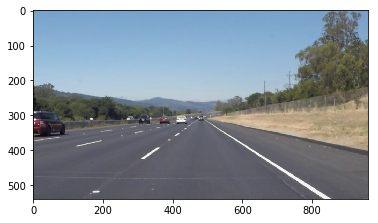

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

******************************************************************
Processing image from file: test_images/solidWhiteCurve.jpg
Frame :  1 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


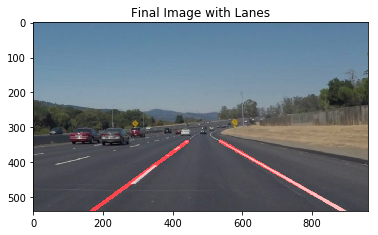

Processed image saved as: test_images/with_lanes_solidWhiteCurve.jpg
******************************************************************
Processing image from file: test_images/solidWhiteRight.jpg
Frame :  1 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


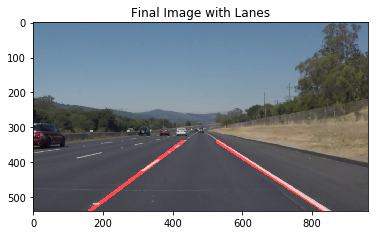

Processed image saved as: test_images/with_lanes_solidWhiteRight.jpg
******************************************************************
Processing image from file: test_images/solidYellowCurve.jpg
Frame :  1 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


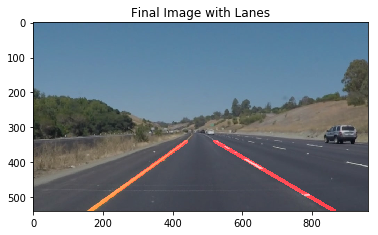

Processed image saved as: test_images/with_lanes_solidYellowCurve.jpg
******************************************************************
Processing image from file: test_images/solidYellowCurve2.jpg
Frame :  1 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


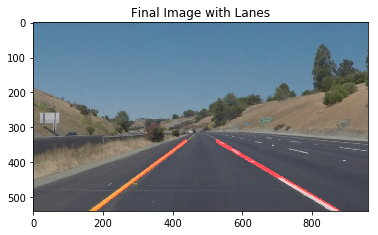

Processed image saved as: test_images/with_lanes_solidYellowCurve2.jpg
******************************************************************
Processing image from file: test_images/solidYellowLeft.jpg
Frame :  1 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


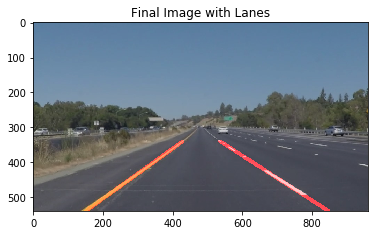

Processed image saved as: test_images/with_lanes_solidYellowLeft.jpg
******************************************************************
Processing image from file: test_images/whiteCarLaneSwitch.jpg
Frame :  1 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


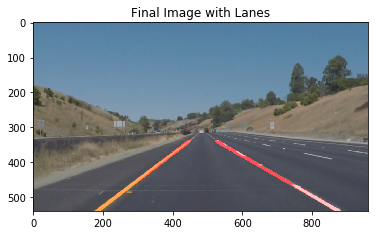

Processed image saved as: test_images/with_lanes_whiteCarLaneSwitch.jpg


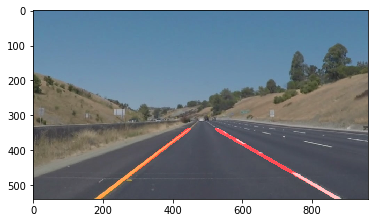

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
def draw_lanes_on_image(file_in, file_out, show_all=True, show_final=True):
    ####################################################################
    #reading in an image
    image = mpimg.imread(file_in)
    print ("******************************************************************")
    print('Processing image from file: '+file_in)
    combo = process_image(image, show_all, show_final)
    
    plt.imshow(combo)
    plt.savefig(file_out)
    print('Processed image saved as: ' + file_out)
   
def process_image(image, show_all=False, show_final=False):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    global frame
    frame += 1
    
    print('Frame : ', str(frame),'-', type(image), 'with dimesions:', image.shape)
    if show_all: show_image(image, 'Original Image')
    
    ####################################################################
    # Make it gray scale
    gray = grayscale(image)
    if show_all: show_image(gray, 'Grayscale Image', cmap='gray')

    ####################################################################
    # Next we'll create a masked image with only region of interest (roi)
    roi_vertices = calculate_region_of_interest(image, show_all)   
    masked_gray = region_of_interest(gray, roi_vertices)
    if show_all: show_image(masked_gray, 'Grayscale Region of Interest', cmap='Greys_r')
    
    ####################################################################
    # "Equalize" the dark gray levels in region of interest, so the lighter
    # lines that represent the lanes are more pronounced, and the canny
    # edge detection will be more precise.
    # 
    # I did this to get challenge_frame_110 to work properly:
    # (-) The road is concrete (light)
    # (-) There are black tire skid marks that are detected by canny and
    #      mess it all up without this step
    #
    equalize_gray_level_in_roi(masked_gray)
    if show_all: show_image(masked_gray, 'Equalized gray level', cmap='Greys_r')
    
    ####################################################################
    edges = find_edges_with_canny(masked_gray)
    if show_all: show_image(edges, 'Canny Edges', cmap='Greys_r')
    
    ####################################################################
    # Find the lanes, using hough transform
    #
    # Define the Hough transform parameters
    rho             = 2          # distance resolution in pixels of the Hough grid
    theta           = np.pi/180  # angular resolution in radians of the Hough grid
    threshold       = 15         # minimum number of votes (intersections in Hough grid cell)
    min_line_len    = 10         # minimum number of pixels making up a line
    max_line_gap    = 5          # maximum gap in pixels between connectable line segments
    
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    if lines is None :
        print ('ERROR: No hough lines found')
        return image
    
    if show_all:
        line_img = np.zeros((edges.shape[0], edges.shape[1], 3), 
                            dtype=np.uint8)
        draw_lines(line_img, lines)
        combo = weighted_img(line_img, image, α=0.8, β=1., λ=0.)
        show_image(combo, 'Hough Lines on Image')

    ####################################################################
    # Draw the lanes on the original image    
    line_img = np.zeros((image.shape[0], image.shape[1], 3), 
                        dtype=np.uint8)
    create_lanes_from_hough_lines(line_img, roi_vertices, lines, thickness=10)
    combo = weighted_img(line_img, image, α=0.8, β=1., λ=0.)
    if show_all or show_final: show_image(combo, 'Final Image with Lanes')

    return combo

def show_image(image, title, cmap=None ):
    plt.title(title)
    if cmap:
        plt.imshow(image, cmap=cmap) # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
    else:
        plt.imshow(image)  
    plt.show()
    
def calculate_region_of_interest(image, show_all):
    imshape = image.shape
    
    # height of roi region
    if roi_height == 0:
        height = int( 0.4*imshape[0] )
    else:
        height = roi_height
        
    # bottom width of roi region
    if roi_width_bot == 0:
        width_bot = int( 0.80 * imshape[1] )
    else:
        width_bot = roi_width_bot
        
    # top width of roi region
    if roi_width_top == 0:
        width_top = int( 0.20 * imshape[1] )
    else:
        width_top = roi_width_top
      
    x_bot_min = roi_shift_bot + int( 0.5 * (imshape[1] - width_bot) )
    x_bot_max = roi_shift_bot + int( 0.5 * (imshape[1] + width_bot) )
    x_top_min = roi_shift_top + int( 0.5 * (imshape[1] - width_top) )
    x_top_max = roi_shift_top + int( 0.5 * (imshape[1] + width_top) )
    
    # eliminate car hood from picture
    y_bot = imshape[0] - hood_size
    y_top = y_bot - height
    
    roi_vertices = np.array([[(x_bot_min,y_bot),
                              (x_top_min, y_top), 
                              (x_top_max, y_top), 
                              (x_bot_max,y_bot)]], dtype=np.int32)
    
    if show_all:
        plt.title('Region of interest on Image. Wb,Wt,H,Sb,St,Sv='+
                  str(x_bot_max-x_bot_min)+','+
                  str(x_top_max-x_top_min)+','+
                  str(y_top-y_bot)+','+
                  str(roi_shift_bot)+','+
                  str(roi_shift_top)+','+
                  str(hood_size))
        line_img = np.zeros((image.shape[0], image.shape[1], 3), 
                            dtype=np.uint8)
        p=roi_vertices[0]
        roi_lines = np.array([[[ p[0, 0], p[0, 1], p[1, 0], p[1, 1] ]],
                              [[ p[1, 0], p[1, 1], p[2, 0], p[2, 1] ]],
                              [[ p[2, 0], p[2, 1], p[3, 0], p[3, 1] ]],
                              [[ p[3, 0], p[3, 1], p[0, 0], p[0, 1] ]]], 
                             dtype=np.int32)
        draw_lines(line_img, roi_lines)
        combo = weighted_img(line_img, image, α=0.8, β=1., λ=0.)
        plt.imshow(combo)
        plt.show()
        
    return roi_vertices

def equalize_gray_level_in_roi(masked_gray): 
    # calculate the average gray level in the region of interest   
    gray_average = int( np.average(masked_gray[np.nonzero(masked_gray)]) )
    
    # assign this average gray level to all regions that are darker than this
    # average value
    masked_gray[ masked_gray < gray_average ] = gray_average

def find_edges_with_canny(masked_gray):    
    # See: http://homepages.inf.ed.ac.uk/rbf/HIPR2/canny.htm
    #
    # Define a kernel size for Gaussian smoothing / blurring
    # Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
    kernel_size = 5
    gaussian_blur(masked_gray, kernel_size)
    
    # Define parameters for Canny and run it
    # thresholds between 0 and 255
    low_threshold = 50
    high_threshold = 150
    edges = canny(masked_gray, low_threshold, high_threshold)
    
    return edges 
   
def create_lanes_from_hough_lines(img, roi_vertices, lines, color=[255, 0, 0], thickness=None):
    """
    This routine attempts to extract the left and right lane from the provided
    hough lines, and draws them on the image.
    
    The method used is as follows:
    (-) each line is extrapolated to the top and bottom of the region of interest
    (-) it will be discarded if the intersection at the top and bottom is outside
        the region of interest.
    (-) the remaining lines are assigned to the left lane if the angle is negative,
        else they are assigned to the right lane
    (-) the locations of the line intersections with the top and bottom of 
        the region of interest are averaged to provide the lane end points
        
    NOTE: This logic ONLY works if the lanes within the region of interest are
          straight.
    """
    #
    # extrapolate start and end points for each line to boundary of region of interest
    #
    y_top_roi    = roi_vertices[0, 1, 1]
    y_bot_roi    = roi_vertices[0, 0, 1]
    
    x_top_roi_min   = roi_vertices[0, 1, 0]
    x_top_roi_max   = roi_vertices[0, 2, 0]
    x_bot_roi_min   = roi_vertices[0, 0, 0]
    x_bot_roi_max   = roi_vertices[0, 3, 0]
    
    x_tops_left   = []
    x_bots_left   = []
    
    x_tops_right   = []
    x_bots_right   = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
        
            # fit a line (y=Ax+B) through this line
            # np.polyfit() returns the coefficients [A, B] of the fit
            fit_line = np.polyfit((x1, x2), (y1, y2), 1)
            A, B = fit_line
            
            # skip lines with very small slope (A)
            if abs(A) < 0.1:
                continue
            
            # calculate intersection with top & bottom boundary of region of interest
            x_top = (y_top_roi - B) / A
            x_bot = (y_bot_roi - B) / A
            
            # skip this line if either the top or bottom points are outside region of interest
            if x_top < x_top_roi_min or x_top > x_top_roi_max:
                continue
            if x_bot < x_bot_roi_min or x_bot > x_bot_roi_max:
                continue
            
            # negative angle line --> left lane
            if A < 0:
                x_tops_left.append(x_top)
                x_bots_left.append(x_bot)
            else:
                x_tops_right.append(x_top)
                x_bots_right.append(x_bot)
    
    # if we didn't find a top or bottom, then skip this image
    if (len(x_tops_left) == 0 or
        len(x_bots_left) == 0 or
        len(x_tops_right) == 0 or
        len(x_bots_right) == 0 ):
        print ('Not all end points found --> skipping this image !!')
        return
    
    x_top_left_average  = int( np.array(x_tops_left).mean()  )
    x_top_right_average = int( np.array(x_tops_right).mean() )
    x_bot_left_average  = int( np.array(x_bots_left).mean()  )
    x_bot_right_average = int( np.array(x_bots_right).mean() )
    
    x_top_left_width  = max(x_tops_left)  - min(x_tops_left)
    x_top_right_width = max(x_tops_right) - min(x_tops_right)
    x_bot_left_width  = max(x_bots_left)  - min(x_bots_left)
    x_bot_right_width = max(x_bots_right) - min(x_bots_right)
    
    if thickness == None:
        thickness = int( 0.5*sum( [x_top_left_width ,
                                   x_top_right_width,
                                   x_bot_left_width ,
                                   x_bot_right_width] ) / 4 )
    
    # plot left lane                 
    cv2.line(img, (x_bot_left_average, y_bot_roi), 
                  (x_top_left_average, y_top_roi), color, thickness)
    
    # plot right lane                 
    cv2.line(img, (x_bot_right_average, y_bot_roi), 
                  (x_top_right_average, y_top_roi), color, thickness)

if __name__ == '__main__':
    # Import everything needed to edit/save/watch video clips
    from moviepy.editor import VideoFileClip
    from IPython.display import HTML
    
    ################################################################
    # process some test files
    #
    file_dir = "test_images"
    files = ['solidWhiteCurve.jpg',
             'solidWhiteRight.jpg',
             'solidYellowCurve.jpg',
             'solidYellowCurve2.jpg',
             'solidYellowLeft.jpg',
             'whiteCarLaneSwitch.jpg']
 
    frame = 0
    hood_size=0
    roi_height=200
    roi_width_bot=810
    roi_width_top=150
    roi_shift_bot=45
    roi_shift_top=15
    for file in files:
        frame = 0
        draw_lanes_on_image(file_in=file_dir+"/"+file, 
                            file_out=file_dir+"/with_lanes_"+file,
                            show_all=False, show_final=True)
          
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
# def process_image is coded up above

Let's try the one with the solid white lane on the right first ...

In [8]:
frame = 0
hood_size=0
roi_height=200
roi_width_bot=810
roi_width_top=150
roi_shift_bot=45
roi_shift_top=15
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Frame :  1 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|          | 0/222 [00:00<?, ?it/s]

Frame :  2 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  0%|          | 1/222 [00:00<00:36,  6.02it/s]

Frame :  3 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  4 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  5 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  6 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  2%|▏         | 5/222 [00:00<00:27,  8.02it/s]

Frame :  7 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  8 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  9 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  10 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  4%|▍         | 9/222 [00:00<00:20, 10.49it/s]

Frame :  11 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  12 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  13 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  14 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  6%|▌         | 13/222 [00:00<00:15, 13.34it/s]

Frame :  15 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  16 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  17 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  18 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  8%|▊         | 17/222 [00:00<00:12, 16.47it/s]

Frame :  19 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  20 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  21 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  22 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  9%|▉         | 21/222 [00:00<00:10, 19.67it/s]

Frame :  23 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  24 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  25 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  26 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 11%|█▏        | 25/222 [00:00<00:08, 22.70it/s]

Frame :  27 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  28 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  29 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  30 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 13%|█▎        | 29/222 [00:00<00:07, 25.78it/s]

Frame :  31 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  32 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  33 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  34 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 15%|█▍        | 33/222 [00:01<00:06, 28.13it/s]

Frame :  35 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  36 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  37 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  38 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 17%|█▋        | 37/222 [00:01<00:06, 29.77it/s]

Frame :  39 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  40 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  41 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  42 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 18%|█▊        | 41/222 [00:01<00:05, 30.97it/s]

Frame :  43 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  44 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  45 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  46 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 20%|██        | 45/222 [00:01<00:05, 31.57it/s]

Frame :  47 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  48 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  49 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  50 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 22%|██▏       | 49/222 [00:01<00:05, 31.32it/s]

Frame :  51 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  52 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  53 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  54 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 24%|██▍       | 53/222 [00:01<00:05, 30.37it/s]

Frame :  55 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  56 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  57 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  58 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 26%|██▌       | 57/222 [00:01<00:05, 29.68it/s]

Frame :  59 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  60 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  61 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  62 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 27%|██▋       | 61/222 [00:01<00:05, 28.58it/s]

Frame :  63 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  64 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  65 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 29%|██▉       | 64/222 [00:02<00:05, 27.55it/s]

Frame :  66 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  67 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  68 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 30%|███       | 67/222 [00:02<00:05, 27.70it/s]

Frame :  69 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  70 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  71 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 32%|███▏      | 70/222 [00:02<00:05, 27.42it/s]

Frame :  72 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  73 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  74 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  75 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 33%|███▎      | 74/222 [00:02<00:05, 28.52it/s]

Frame :  76 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  77 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  78 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  79 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 35%|███▌      | 78/222 [00:02<00:04, 29.16it/s]

Frame :  80 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  81 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  82 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 36%|███▋      | 81/222 [00:02<00:04, 29.23it/s]

Frame :  83 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  84 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  85 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 38%|███▊      | 84/222 [00:02<00:04, 29.37it/s]

Frame :  86 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  87 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  88 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  89 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 40%|███▉      | 88/222 [00:02<00:04, 29.45it/s]

Frame :  90 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  91 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  92 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 41%|████      | 91/222 [00:03<00:04, 29.44it/s]

Frame :  93 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  94 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  95 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  96 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 43%|████▎     | 95/222 [00:03<00:04, 29.43it/s]

Frame :  97 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  98 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  99 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 44%|████▍     | 98/222 [00:03<00:04, 29.08it/s]

Frame :  100 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  101 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  102 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 45%|████▌     | 101/222 [00:03<00:04, 28.76it/s]

Frame :  103 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  104 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  105 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 47%|████▋     | 104/222 [00:03<00:04, 29.12it/s]

Frame :  106 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  107 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  108 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 48%|████▊     | 107/222 [00:03<00:03, 29.12it/s]

Frame :  109 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  110 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  111 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 50%|████▉     | 110/222 [00:03<00:03, 28.46it/s]

Frame :  112 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  113 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  114 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 51%|█████     | 113/222 [00:03<00:03, 28.82it/s]

Frame :  115 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  116 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  117 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 52%|█████▏    | 116/222 [00:03<00:03, 29.16it/s]

Frame :  118 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  119 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  120 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  121 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 54%|█████▍    | 120/222 [00:03<00:03, 29.89it/s]

Frame :  122 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  123 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  124 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  125 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 56%|█████▌    | 124/222 [00:04<00:03, 30.15it/s]

Frame :  126 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  127 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  128 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  129 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 58%|█████▊    | 128/222 [00:04<00:03, 31.04it/s]

Frame :  130 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  131 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  132 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  133 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 59%|█████▉    | 132/222 [00:04<00:02, 30.74it/s]

Frame :  134 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  135 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  136 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  137 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 61%|██████▏   | 136/222 [00:04<00:02, 30.68it/s]

Frame :  138 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  139 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  140 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  141 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 63%|██████▎   | 140/222 [00:04<00:02, 30.56it/s]

Frame :  142 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  143 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  144 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  145 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 65%|██████▍   | 144/222 [00:04<00:02, 30.77it/s]

Frame :  146 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  147 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  148 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  149 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 67%|██████▋   | 148/222 [00:04<00:02, 30.98it/s]

Frame :  150 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  151 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  152 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  153 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 68%|██████▊   | 152/222 [00:05<00:02, 31.28it/s]

Frame :  154 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  155 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  156 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  157 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 70%|███████   | 156/222 [00:05<00:02, 31.72it/s]

Frame :  158 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  159 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  160 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  161 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 72%|███████▏  | 160/222 [00:05<00:01, 31.35it/s]

Frame :  162 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  163 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  164 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  165 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 74%|███████▍  | 164/222 [00:05<00:01, 30.53it/s]

Frame :  166 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  167 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  168 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  169 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 76%|███████▌  | 168/222 [00:05<00:01, 29.71it/s]

Frame :  170 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  171 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  172 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 77%|███████▋  | 171/222 [00:05<00:01, 29.53it/s]

Frame :  173 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  174 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  175 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  176 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 79%|███████▉  | 175/222 [00:05<00:01, 30.03it/s]

Frame :  177 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  178 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  179 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  180 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 81%|████████  | 179/222 [00:05<00:01, 30.11it/s]

Frame :  181 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  182 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  183 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  184 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 82%|████████▏ | 183/222 [00:06<00:01, 29.63it/s]

Frame :  185 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  186 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  187 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 84%|████████▍ | 186/222 [00:06<00:01, 29.13it/s]

Frame :  188 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  189 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  190 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 85%|████████▌ | 189/222 [00:06<00:01, 29.30it/s]

Frame :  191 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  192 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  193 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 86%|████████▋ | 192/222 [00:06<00:01, 27.55it/s]

Frame :  194 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  195 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  196 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 88%|████████▊ | 195/222 [00:06<00:01, 26.31it/s]

Frame :  197 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  198 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  199 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 89%|████████▉ | 198/222 [00:06<00:00, 26.04it/s]

Frame :  200 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  201 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  202 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 91%|█████████ | 201/222 [00:06<00:00, 26.54it/s]

Frame :  203 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  204 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  205 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 92%|█████████▏| 204/222 [00:06<00:00, 27.34it/s]

Frame :  206 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  207 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  208 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 93%|█████████▎| 207/222 [00:06<00:00, 27.24it/s]

Frame :  209 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  210 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  211 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  212 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 95%|█████████▌| 211/222 [00:07<00:00, 28.21it/s]

Frame :  213 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  214 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  215 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  216 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 97%|█████████▋| 215/222 [00:07<00:00, 29.25it/s]

Frame :  217 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  218 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  219 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  220 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 99%|█████████▊| 219/222 [00:07<00:00, 30.57it/s]

Frame :  221 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  222 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


100%|█████████▉| 221/222 [00:07<00:00, 29.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 7.81 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
frame = 0
hood_size=0
roi_height=200
roi_width_bot=810
roi_width_top=150
roi_shift_bot=45
roi_shift_top=15
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Frame :  1 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|          | 0/682 [00:00<?, ?it/s]

Frame :  2 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  0%|          | 1/682 [00:00<01:44,  6.49it/s]

Frame :  3 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  4 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  5 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  6 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  1%|          | 5/682 [00:00<01:18,  8.58it/s]

Frame :  7 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  8 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  9 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  10 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  1%|▏         | 9/682 [00:00<01:00, 11.11it/s]

Frame :  11 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  12 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  13 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  14 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  2%|▏         | 13/682 [00:00<00:47, 14.02it/s]

Frame :  15 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  16 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  17 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  18 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  2%|▏         | 17/682 [00:00<00:39, 16.90it/s]

Frame :  19 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  20 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  21 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  22 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  3%|▎         | 21/682 [00:00<00:33, 19.95it/s]

Frame :  23 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  24 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  25 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  26 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  4%|▎         | 25/682 [00:00<00:28, 22.84it/s]

Frame :  27 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  28 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  29 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  30 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  4%|▍         | 29/682 [00:00<00:26, 25.08it/s]

Frame :  31 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  32 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  33 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  34 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  5%|▍         | 33/682 [00:01<00:24, 26.93it/s]

Frame :  35 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  36 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  37 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  38 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  5%|▌         | 37/682 [00:01<00:22, 28.63it/s]

Frame :  39 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  40 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  41 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  42 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  6%|▌         | 41/682 [00:01<00:21, 30.03it/s]

Frame :  43 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  44 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  45 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  46 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  7%|▋         | 45/682 [00:01<00:20, 30.46it/s]

Frame :  47 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  48 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  49 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  50 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  7%|▋         | 49/682 [00:01<00:21, 30.13it/s]

Frame :  51 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  52 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  53 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  54 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  8%|▊         | 53/682 [00:01<00:21, 29.45it/s]

Frame :  55 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  56 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  57 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  58 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  8%|▊         | 57/682 [00:01<00:21, 28.80it/s]

Frame :  59 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  60 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  61 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  9%|▉         | 60/682 [00:01<00:21, 28.73it/s]

Frame :  62 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  63 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  64 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


  9%|▉         | 63/682 [00:02<00:22, 27.96it/s]

Frame :  65 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  66 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  67 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 10%|▉         | 66/682 [00:02<00:22, 27.45it/s]

Frame :  68 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  69 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  70 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 10%|█         | 69/682 [00:02<00:22, 27.39it/s]

Frame :  71 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  72 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  73 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 11%|█         | 72/682 [00:02<00:22, 27.43it/s]

Frame :  74 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  75 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  76 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  77 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 11%|█         | 76/682 [00:02<00:21, 28.35it/s]

Frame :  78 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  79 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  80 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 12%|█▏        | 79/682 [00:02<00:21, 28.58it/s]

Frame :  81 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  82 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  83 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 12%|█▏        | 82/682 [00:02<00:21, 28.33it/s]

Frame :  84 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  85 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  86 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 12%|█▏        | 85/682 [00:02<00:21, 28.24it/s]

Frame :  87 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  88 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  89 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 13%|█▎        | 88/682 [00:02<00:20, 28.42it/s]

Frame :  90 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  91 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  92 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 13%|█▎        | 91/682 [00:03<00:20, 28.14it/s]

Frame :  93 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  94 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  95 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 14%|█▍        | 94/682 [00:03<00:21, 27.88it/s]

Frame :  96 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  97 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  98 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 14%|█▍        | 97/682 [00:03<00:20, 28.00it/s]

Frame :  99 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  100 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  101 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 15%|█▍        | 100/682 [00:03<00:21, 27.55it/s]

Frame :  102 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  103 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  104 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 15%|█▌        | 103/682 [00:03<00:20, 27.69it/s]

Frame :  105 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  106 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  107 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 16%|█▌        | 106/682 [00:03<00:21, 27.34it/s]

Frame :  108 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  109 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  110 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 16%|█▌        | 109/682 [00:03<00:20, 27.47it/s]

Frame :  111 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  112 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  113 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 16%|█▋        | 112/682 [00:03<00:20, 27.18it/s]

Frame :  114 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  115 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  116 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 17%|█▋        | 115/682 [00:03<00:21, 26.84it/s]

Frame :  117 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  118 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  119 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 17%|█▋        | 118/682 [00:04<00:20, 26.97it/s]

Frame :  120 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  121 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  122 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 18%|█▊        | 121/682 [00:04<00:20, 27.21it/s]

Frame :  123 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  124 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  125 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 18%|█▊        | 124/682 [00:04<00:20, 27.45it/s]

Frame :  126 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  127 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  128 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 19%|█▊        | 127/682 [00:04<00:19, 28.17it/s]

Frame :  129 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  130 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  131 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 19%|█▉        | 130/682 [00:04<00:19, 28.45it/s]

Frame :  132 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  133 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  134 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  135 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 20%|█▉        | 134/682 [00:04<00:18, 29.36it/s]

Frame :  136 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  137 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  138 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 20%|██        | 137/682 [00:04<00:18, 28.70it/s]

Frame :  139 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  140 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  141 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 21%|██        | 140/682 [00:04<00:18, 28.83it/s]

Frame :  142 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  143 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  144 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 21%|██        | 143/682 [00:04<00:18, 28.75it/s]

Frame :  145 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  146 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  147 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 21%|██▏       | 146/682 [00:05<00:18, 29.11it/s]

Frame :  148 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  149 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  150 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  151 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 22%|██▏       | 150/682 [00:05<00:17, 29.66it/s]

Frame :  152 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  153 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  154 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  155 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 23%|██▎       | 154/682 [00:05<00:17, 30.32it/s]

Frame :  156 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  157 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  158 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  159 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 23%|██▎       | 158/682 [00:05<00:17, 30.38it/s]

Frame :  160 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  161 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  162 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  163 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 24%|██▍       | 162/682 [00:05<00:17, 30.36it/s]

Frame :  164 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  165 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  166 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  167 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 24%|██▍       | 166/682 [00:05<00:17, 29.47it/s]

Frame :  168 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  169 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  170 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 25%|██▍       | 169/682 [00:05<00:17, 28.94it/s]

Frame :  171 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  172 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  173 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 25%|██▌       | 172/682 [00:05<00:17, 28.99it/s]

Frame :  174 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  175 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  176 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 26%|██▌       | 175/682 [00:06<00:17, 28.37it/s]

Frame :  177 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  178 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  179 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 26%|██▌       | 178/682 [00:06<00:18, 27.88it/s]

Frame :  180 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  181 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  182 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 27%|██▋       | 181/682 [00:06<00:17, 27.92it/s]

Frame :  183 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  184 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  185 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 27%|██▋       | 184/682 [00:06<00:17, 27.80it/s]

Frame :  186 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  187 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  188 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 27%|██▋       | 187/682 [00:06<00:18, 27.26it/s]

Frame :  189 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  190 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  191 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 28%|██▊       | 190/682 [00:06<00:18, 27.12it/s]

Frame :  192 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  193 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  194 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 28%|██▊       | 193/682 [00:06<00:18, 25.76it/s]

Frame :  195 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  196 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  197 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 29%|██▊       | 196/682 [00:06<00:19, 25.33it/s]

Frame :  198 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  199 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  200 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 29%|██▉       | 199/682 [00:06<00:18, 25.95it/s]

Frame :  201 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  202 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  203 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 30%|██▉       | 202/682 [00:07<00:18, 26.61it/s]

Frame :  204 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  205 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  206 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 30%|███       | 205/682 [00:07<00:17, 27.10it/s]

Frame :  207 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  208 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  209 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 30%|███       | 208/682 [00:07<00:16, 27.91it/s]

Frame :  210 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  211 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  212 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  213 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 31%|███       | 212/682 [00:07<00:16, 28.89it/s]

Frame :  214 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  215 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  216 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 32%|███▏      | 215/682 [00:07<00:16, 28.88it/s]

Frame :  217 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  218 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  219 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  220 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 32%|███▏      | 219/682 [00:07<00:15, 29.55it/s]

Frame :  221 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  222 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  223 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  224 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 33%|███▎      | 223/682 [00:07<00:15, 29.97it/s]

Frame :  225 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  226 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  227 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  228 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 33%|███▎      | 227/682 [00:07<00:15, 30.14it/s]

Frame :  229 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  230 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  231 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  232 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 34%|███▍      | 231/682 [00:08<00:15, 29.85it/s]

Frame :  233 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  234 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  235 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 34%|███▍      | 234/682 [00:08<00:15, 29.72it/s]

Frame :  236 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  237 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  238 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  239 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 35%|███▍      | 238/682 [00:08<00:14, 29.96it/s]

Frame :  240 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  241 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  242 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 35%|███▌      | 241/682 [00:08<00:14, 29.88it/s]

Frame :  243 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  244 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  245 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  246 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 36%|███▌      | 245/682 [00:08<00:14, 30.41it/s]

Frame :  247 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  248 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  249 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  250 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 37%|███▋      | 249/682 [00:08<00:14, 30.73it/s]

Frame :  251 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  252 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  253 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  254 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 37%|███▋      | 253/682 [00:08<00:13, 30.81it/s]

Frame :  255 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  256 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  257 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  258 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 38%|███▊      | 257/682 [00:08<00:13, 30.59it/s]

Frame :  259 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  260 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  261 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  262 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 38%|███▊      | 261/682 [00:09<00:13, 30.78it/s]

Frame :  263 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  264 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  265 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  266 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 39%|███▉      | 265/682 [00:09<00:13, 31.06it/s]

Frame :  267 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  268 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  269 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  270 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 39%|███▉      | 269/682 [00:09<00:13, 30.76it/s]

Frame :  271 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  272 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  273 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  274 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 40%|████      | 273/682 [00:09<00:13, 30.48it/s]

Frame :  275 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  276 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  277 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  278 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 41%|████      | 277/682 [00:09<00:13, 30.64it/s]

Frame :  279 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  280 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  281 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  282 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 41%|████      | 281/682 [00:09<00:13, 30.05it/s]

Frame :  283 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  284 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  285 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  286 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 42%|████▏     | 285/682 [00:09<00:13, 29.92it/s]

Frame :  287 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  288 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  289 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 42%|████▏     | 288/682 [00:09<00:13, 29.07it/s]

Frame :  290 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  291 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  292 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 43%|████▎     | 291/682 [00:10<00:13, 28.67it/s]

Frame :  293 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  294 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  295 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 43%|████▎     | 294/682 [00:10<00:13, 28.08it/s]

Frame :  296 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  297 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  298 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  299 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 44%|████▎     | 298/682 [00:10<00:13, 28.90it/s]

Frame :  300 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  301 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  302 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 44%|████▍     | 301/682 [00:10<00:13, 28.96it/s]

Frame :  303 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  304 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  305 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 45%|████▍     | 304/682 [00:10<00:13, 28.60it/s]

Frame :  306 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  307 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  308 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 45%|████▌     | 307/682 [00:10<00:13, 28.59it/s]

Frame :  309 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  310 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  311 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  312 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 46%|████▌     | 311/682 [00:10<00:12, 29.14it/s]

Frame :  313 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  314 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  315 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 46%|████▌     | 314/682 [00:10<00:12, 29.22it/s]

Frame :  316 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  317 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  318 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 46%|████▋     | 317/682 [00:10<00:13, 27.51it/s]

Frame :  319 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  320 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  321 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 47%|████▋     | 320/682 [00:11<00:13, 27.74it/s]

Frame :  322 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  323 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  324 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 47%|████▋     | 323/682 [00:11<00:12, 28.14it/s]

Frame :  325 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  326 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  327 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 48%|████▊     | 326/682 [00:11<00:12, 28.11it/s]

Frame :  328 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  329 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  330 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 48%|████▊     | 329/682 [00:11<00:12, 28.09it/s]

Frame :  331 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  332 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  333 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 49%|████▊     | 332/682 [00:11<00:12, 28.31it/s]

Frame :  334 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  335 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  336 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  337 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 49%|████▉     | 336/682 [00:11<00:11, 29.13it/s]

Frame :  338 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  339 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  340 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  341 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 50%|████▉     | 340/682 [00:11<00:11, 29.15it/s]

Frame :  342 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  343 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  344 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 50%|█████     | 343/682 [00:11<00:11, 29.23it/s]

Frame :  345 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  346 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  347 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  348 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 51%|█████     | 347/682 [00:11<00:11, 29.81it/s]

Frame :  349 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  350 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  351 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 51%|█████▏    | 350/682 [00:12<00:11, 29.51it/s]

Frame :  352 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  353 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  354 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 52%|█████▏    | 353/682 [00:12<00:11, 29.57it/s]

Frame :  355 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  356 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  357 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 52%|█████▏    | 356/682 [00:12<00:10, 29.69it/s]

Frame :  358 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  359 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  360 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  361 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 53%|█████▎    | 360/682 [00:12<00:10, 29.81it/s]

Frame :  362 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  363 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  364 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 53%|█████▎    | 363/682 [00:12<00:10, 29.69it/s]

Frame :  365 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  366 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  367 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  368 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 54%|█████▍    | 367/682 [00:12<00:10, 30.14it/s]

Frame :  369 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  370 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  371 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  372 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 54%|█████▍    | 371/682 [00:12<00:10, 30.53it/s]

Frame :  373 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  374 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  375 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  376 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 55%|█████▍    | 375/682 [00:12<00:10, 30.46it/s]

Frame :  377 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  378 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  379 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  380 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 56%|█████▌    | 379/682 [00:13<00:10, 30.00it/s]

Frame :  381 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  382 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  383 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  384 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 56%|█████▌    | 383/682 [00:13<00:09, 30.23it/s]

Frame :  385 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  386 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  387 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  388 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 57%|█████▋    | 387/682 [00:13<00:09, 29.91it/s]

Frame :  389 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  390 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  391 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  392 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 57%|█████▋    | 391/682 [00:13<00:09, 30.09it/s]

Frame :  393 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  394 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  395 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  396 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 58%|█████▊    | 395/682 [00:13<00:09, 29.75it/s]

Frame :  397 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  398 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  399 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  400 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 59%|█████▊    | 399/682 [00:13<00:09, 29.65it/s]

Frame :  401 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  402 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  403 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  404 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 59%|█████▉    | 403/682 [00:13<00:09, 30.11it/s]

Frame :  405 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  406 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  407 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  408 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 60%|█████▉    | 407/682 [00:13<00:09, 30.51it/s]

Frame :  409 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  410 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  411 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  412 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 60%|██████    | 411/682 [00:14<00:08, 30.52it/s]

Frame :  413 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  414 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  415 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  416 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 61%|██████    | 415/682 [00:14<00:08, 30.18it/s]

Frame :  417 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  418 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  419 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  420 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 61%|██████▏   | 419/682 [00:14<00:08, 30.49it/s]

Frame :  421 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  422 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  423 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  424 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 62%|██████▏   | 423/682 [00:14<00:08, 30.50it/s]

Frame :  425 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  426 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  427 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  428 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 63%|██████▎   | 427/682 [00:14<00:08, 30.51it/s]

Frame :  429 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  430 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  431 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  432 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 63%|██████▎   | 431/682 [00:14<00:08, 30.87it/s]

Frame :  433 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  434 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  435 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  436 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 64%|██████▍   | 435/682 [00:14<00:08, 30.77it/s]

Frame :  437 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  438 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  439 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  440 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 64%|██████▍   | 439/682 [00:14<00:07, 30.49it/s]

Frame :  441 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  442 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  443 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  444 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 65%|██████▍   | 443/682 [00:15<00:07, 30.43it/s]

Frame :  445 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  446 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  447 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  448 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 66%|██████▌   | 447/682 [00:15<00:07, 30.39it/s]

Frame :  449 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  450 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  451 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  452 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 66%|██████▌   | 451/682 [00:15<00:07, 30.57it/s]

Frame :  453 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  454 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  455 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  456 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 67%|██████▋   | 455/682 [00:15<00:07, 30.77it/s]

Frame :  457 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  458 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  459 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  460 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 67%|██████▋   | 459/682 [00:15<00:07, 30.77it/s]

Frame :  461 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  462 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  463 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  464 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 68%|██████▊   | 463/682 [00:15<00:07, 30.49it/s]

Frame :  465 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  466 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  467 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  468 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 68%|██████▊   | 467/682 [00:15<00:07, 30.22it/s]

Frame :  469 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  470 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  471 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  472 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 69%|██████▉   | 471/682 [00:16<00:07, 29.97it/s]

Frame :  473 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  474 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  475 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 70%|██████▉   | 474/682 [00:16<00:06, 29.80it/s]

Frame :  476 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  477 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  478 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 70%|██████▉   | 477/682 [00:16<00:06, 29.42it/s]

Frame :  479 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  480 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  481 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  482 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 71%|███████   | 481/682 [00:16<00:06, 29.95it/s]

Frame :  483 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  484 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  485 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 71%|███████   | 484/682 [00:16<00:06, 29.96it/s]

Frame :  486 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  487 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  488 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  489 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 72%|███████▏  | 488/682 [00:16<00:06, 30.34it/s]

Frame :  490 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  491 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  492 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  493 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 72%|███████▏  | 492/682 [00:16<00:06, 30.19it/s]

Frame :  494 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  495 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  496 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  497 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 73%|███████▎  | 496/682 [00:16<00:06, 30.15it/s]

Frame :  498 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  499 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  500 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  501 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 73%|███████▎  | 500/682 [00:17<00:06, 29.93it/s]

Frame :  502 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  503 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  504 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  505 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 74%|███████▍  | 504/682 [00:17<00:05, 30.66it/s]

Frame :  506 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  507 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  508 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  509 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 74%|███████▍  | 508/682 [00:17<00:05, 30.98it/s]

Frame :  510 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  511 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  512 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  513 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 75%|███████▌  | 512/682 [00:17<00:05, 30.63it/s]

Frame :  514 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  515 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  516 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  517 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 76%|███████▌  | 516/682 [00:17<00:05, 30.53it/s]

Frame :  518 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  519 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  520 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  521 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 76%|███████▌  | 520/682 [00:17<00:05, 29.98it/s]

Frame :  522 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  523 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  524 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  525 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 77%|███████▋  | 524/682 [00:17<00:05, 29.61it/s]

Frame :  526 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  527 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  528 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 77%|███████▋  | 527/682 [00:17<00:05, 28.46it/s]

Frame :  529 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  530 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  531 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  532 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 78%|███████▊  | 531/682 [00:18<00:05, 28.73it/s]

Frame :  533 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  534 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  535 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 78%|███████▊  | 534/682 [00:18<00:05, 28.52it/s]

Frame :  536 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  537 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  538 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  539 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 79%|███████▉  | 538/682 [00:18<00:04, 29.29it/s]

Frame :  540 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  541 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  542 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 79%|███████▉  | 541/682 [00:18<00:04, 28.82it/s]

Frame :  543 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  544 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  545 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 80%|███████▉  | 544/682 [00:18<00:04, 29.08it/s]

Frame :  546 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  547 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  548 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  549 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 80%|████████  | 548/682 [00:18<00:04, 29.63it/s]

Frame :  550 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  551 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  552 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  553 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 81%|████████  | 552/682 [00:18<00:04, 30.16it/s]

Frame :  554 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  555 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  556 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  557 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 82%|████████▏ | 556/682 [00:18<00:04, 30.14it/s]

Frame :  558 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  559 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  560 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  561 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 82%|████████▏ | 560/682 [00:19<00:04, 29.65it/s]

Frame :  562 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  563 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  564 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 83%|████████▎ | 563/682 [00:19<00:04, 28.98it/s]

Frame :  565 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  566 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  567 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 83%|████████▎ | 566/682 [00:19<00:03, 29.19it/s]

Frame :  568 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  569 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  570 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  571 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 84%|████████▎ | 570/682 [00:19<00:03, 29.51it/s]

Frame :  572 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  573 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  574 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  575 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 84%|████████▍ | 574/682 [00:19<00:03, 29.88it/s]

Frame :  576 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  577 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  578 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  579 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 85%|████████▍ | 578/682 [00:19<00:03, 30.21it/s]

Frame :  580 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  581 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  582 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  583 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 85%|████████▌ | 582/682 [00:19<00:03, 30.30it/s]

Frame :  584 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  585 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  586 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  587 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 86%|████████▌ | 586/682 [00:19<00:03, 29.76it/s]

Frame :  588 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  589 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  590 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  591 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 87%|████████▋ | 590/682 [00:20<00:03, 30.06it/s]

Frame :  592 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  593 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  594 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  595 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 87%|████████▋ | 594/682 [00:20<00:02, 30.40it/s]

Frame :  596 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  597 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  598 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  599 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 88%|████████▊ | 598/682 [00:20<00:02, 30.51it/s]

Frame :  600 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  601 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  602 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  603 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 88%|████████▊ | 602/682 [00:20<00:02, 30.45it/s]

Frame :  604 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  605 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  606 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  607 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 89%|████████▉ | 606/682 [00:20<00:02, 30.68it/s]

Frame :  608 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  609 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  610 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  611 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 89%|████████▉ | 610/682 [00:20<00:02, 30.64it/s]

Frame :  612 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  613 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  614 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  615 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 90%|█████████ | 614/682 [00:20<00:02, 30.75it/s]

Frame :  616 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  617 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  618 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  619 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 91%|█████████ | 618/682 [00:20<00:02, 30.54it/s]

Frame :  620 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  621 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  622 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  623 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 91%|█████████ | 622/682 [00:21<00:02, 29.85it/s]

Frame :  624 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  625 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  626 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 92%|█████████▏| 625/682 [00:21<00:01, 29.90it/s]

Frame :  627 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  628 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  629 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 92%|█████████▏| 628/682 [00:21<00:01, 29.93it/s]

Frame :  630 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  631 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  632 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 93%|█████████▎| 631/682 [00:21<00:01, 29.77it/s]

Frame :  633 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  634 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  635 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  636 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 93%|█████████▎| 635/682 [00:21<00:01, 29.93it/s]

Frame :  637 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  638 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  639 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  640 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 94%|█████████▎| 639/682 [00:21<00:01, 30.45it/s]

Frame :  641 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  642 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  643 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  644 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 94%|█████████▍| 643/682 [00:21<00:01, 30.68it/s]

Frame :  645 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  646 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  647 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  648 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 95%|█████████▍| 647/682 [00:21<00:01, 30.71it/s]

Frame :  649 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  650 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  651 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  652 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 95%|█████████▌| 651/682 [00:22<00:01, 30.52it/s]

Frame :  653 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  654 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  655 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  656 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 96%|█████████▌| 655/682 [00:22<00:00, 30.52it/s]

Frame :  657 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  658 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  659 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  660 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 97%|█████████▋| 659/682 [00:22<00:00, 30.52it/s]

Frame :  661 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  662 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  663 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  664 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 97%|█████████▋| 663/682 [00:22<00:00, 30.53it/s]

Frame :  665 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  666 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  667 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  668 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 98%|█████████▊| 667/682 [00:22<00:00, 30.74it/s]

Frame :  669 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  670 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  671 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  672 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 98%|█████████▊| 671/682 [00:22<00:00, 30.61it/s]

Frame :  673 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  674 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  675 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  676 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 99%|█████████▉| 675/682 [00:22<00:00, 30.17it/s]

Frame :  677 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  678 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  679 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  680 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


100%|█████████▉| 679/682 [00:22<00:00, 30.07it/s]

Frame :  681 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
Frame :  682 - <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


100%|█████████▉| 681/682 [00:23<00:00, 29.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 23.5 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

---
My pipeline was largely created based on frame 110 of the challenge video:
<figure>
 <img src="challenge_frame_110_image-0.jpg" width="380" alt="Original" />
</figure>

The steps take are best explained by this sequence of pictures:

<figure>
 <img src="challenge_frame_110_image-1.jpg" width="380" alt="Grayscale" />
</figure>

<figure>
 <img src="challenge_frame_110_image-2.jpg" width="380" alt="ROI" />
</figure>

<figure>
 <img src="challenge_frame_110_image-3.jpg" width="380" alt="Gray Scale ROI" />
</figure>

<figure>
 <img src="challenge_frame_110_image-4.jpg" width="380" alt="Equalized" />
</figure>

<figure>
 <img src="challenge_frame_110_image-5.jpg" width="380" alt="Canny Edges" />
</figure>

<figure>
 <img src="challenge_frame_110_image-6.jpg" width="380" alt="Hough Lines" />
</figure>

<figure>
 <img src="challenge_frame_110_image-7.jpg" width="380" alt="Final Image" />
</figure>
 
Some key decisions I made along the way:

1. I parameterized the inputs for the region of interest (roi):
        hood_size
        roi_height
        roi_width_bot
        roi_width_top
        roi_shift_bot
        roi_shift_top
    
    My logic  strongly depends on having a well defined region of interest.

2. I 'equalize' the grey level in the region of interest.
...This greatly improves the visibility of the lanes in the image.
...See function: equalize_gray_level_in_roi
    
3. All images and videos have straight lanes in the region of interest. I make use of this fact, in two ways:
..* To select what hough lines belong to the lanes, I extrapolate them to the top and bottom of the region of interest. If they intersect outside of the region of interest then they obviously are not part of the lanes.

..* To determine the end points of the lanes, I simply average the intersection points of the selected lines with the top and bottom of the region of interest. The lanes are then drawn with a fixed thickness.

## Weaknesses

The weakest aspects of my approach are:

* The requirement to manually set the region of interest. If the car drifts, I can see that we lose the lanes very easily.

* The 'equalizing' of gray level in the region of interest does not seem so robust. It works ok for all tests, but I can imagine it will fail on other cases.

* The logic only works on straight lines.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [14]:
frame = 0
hood_size=55
roi_height=200
roi_width_bot=840
roi_width_top=180
roi_shift_bot=35
roi_shift_top=25
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

  self.nchannels))



Frame :  1 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  0%|          | 0/251 [00:00<?, ?it/s]

Frame :  2 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  0%|          | 1/251 [00:00<00:43,  5.75it/s]

Frame :  3 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  4 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  1%|          | 3/251 [00:00<00:34,  7.26it/s]

Frame :  5 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  6 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  2%|▏         | 5/251 [00:00<00:27,  8.90it/s]

Frame :  7 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  8 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  3%|▎         | 7/251 [00:00<00:23, 10.56it/s]

Frame :  9 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  10 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  4%|▎         | 9/251 [00:00<00:19, 12.24it/s]

Frame :  11 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  12 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  4%|▍         | 11/251 [00:00<00:17, 13.76it/s]

Frame :  13 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  14 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  5%|▌         | 13/251 [00:00<00:16, 14.49it/s]

Frame :  15 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  16 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  6%|▌         | 15/251 [00:00<00:15, 15.43it/s]

Frame :  17 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  18 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  7%|▋         | 17/251 [00:01<00:14, 16.52it/s]

Frame :  19 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  20 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  8%|▊         | 19/251 [00:01<00:13, 16.95it/s]

Frame :  21 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  22 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  8%|▊         | 21/251 [00:01<00:13, 17.66it/s]

Frame :  23 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  24 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  25 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 10%|▉         | 24/251 [00:01<00:12, 18.31it/s]

Frame :  26 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  27 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 10%|█         | 26/251 [00:01<00:12, 18.68it/s]

Frame :  28 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  29 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 11%|█         | 28/251 [00:01<00:11, 19.00it/s]

Frame :  30 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  31 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 12%|█▏        | 30/251 [00:01<00:11, 18.91it/s]

Frame :  32 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  33 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 13%|█▎        | 32/251 [00:01<00:11, 18.53it/s]

Frame :  34 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  35 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 14%|█▎        | 34/251 [00:01<00:11, 18.68it/s]

Frame :  36 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  37 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 14%|█▍        | 36/251 [00:02<00:11, 18.68it/s]

Frame :  38 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  39 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 15%|█▌        | 38/251 [00:02<00:11, 18.95it/s]

Frame :  40 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  41 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 16%|█▌        | 40/251 [00:02<00:11, 18.30it/s]

Frame :  42 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  43 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 17%|█▋        | 42/251 [00:02<00:11, 17.78it/s]

Frame :  44 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  45 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 18%|█▊        | 44/251 [00:02<00:11, 17.80it/s]

Frame :  46 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  47 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 18%|█▊        | 46/251 [00:02<00:11, 18.11it/s]

Frame :  48 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  49 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 19%|█▉        | 48/251 [00:02<00:11, 18.43it/s]

Frame :  50 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  51 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 20%|█▉        | 50/251 [00:02<00:11, 18.15it/s]

Frame :  52 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  53 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 21%|██        | 52/251 [00:02<00:11, 17.40it/s]

Frame :  54 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  55 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 22%|██▏       | 54/251 [00:03<00:11, 17.09it/s]

Frame :  56 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  57 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 22%|██▏       | 56/251 [00:03<00:11, 17.09it/s]

Frame :  58 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  59 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 23%|██▎       | 58/251 [00:03<00:11, 16.70it/s]

Frame :  60 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  61 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 24%|██▍       | 60/251 [00:03<00:11, 16.25it/s]

Frame :  62 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  63 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 25%|██▍       | 62/251 [00:03<00:11, 15.90it/s]

Frame :  64 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  65 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 25%|██▌       | 64/251 [00:03<00:11, 15.89it/s]

Frame :  66 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  67 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 26%|██▋       | 66/251 [00:03<00:11, 15.81it/s]

Frame :  68 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  69 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 27%|██▋       | 68/251 [00:03<00:11, 15.87it/s]

Frame :  70 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  71 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 28%|██▊       | 70/251 [00:04<00:11, 15.29it/s]

Frame :  72 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  73 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 29%|██▊       | 72/251 [00:04<00:11, 15.94it/s]

Frame :  74 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  75 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 29%|██▉       | 74/251 [00:04<00:11, 15.51it/s]

Frame :  76 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  77 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 30%|███       | 76/251 [00:04<00:11, 15.88it/s]

Frame :  78 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  79 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 31%|███       | 78/251 [00:04<00:10, 16.11it/s]

Frame :  80 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  81 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 32%|███▏      | 80/251 [00:04<00:10, 16.51it/s]

Frame :  82 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  83 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 33%|███▎      | 82/251 [00:04<00:10, 16.68it/s]

Frame :  84 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  85 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 33%|███▎      | 84/251 [00:04<00:10, 16.68it/s]

Frame :  86 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  87 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 34%|███▍      | 86/251 [00:05<00:09, 16.55it/s]

Frame :  88 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  89 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 35%|███▌      | 88/251 [00:05<00:09, 16.54it/s]

Frame :  90 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  91 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 36%|███▌      | 90/251 [00:05<00:10, 15.98it/s]

Frame :  92 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  93 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 37%|███▋      | 92/251 [00:05<00:10, 15.69it/s]

Frame :  94 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  95 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 37%|███▋      | 94/251 [00:05<00:10, 15.17it/s]

Frame :  96 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  97 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 38%|███▊      | 96/251 [00:05<00:10, 14.44it/s]

Frame :  98 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  99 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 39%|███▉      | 98/251 [00:05<00:10, 14.24it/s]

Frame :  100 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  101 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 40%|███▉      | 100/251 [00:06<00:10, 14.38it/s]

Frame :  102 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  103 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 41%|████      | 102/251 [00:06<00:10, 14.79it/s]

Frame :  104 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  105 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 41%|████▏     | 104/251 [00:06<00:10, 14.67it/s]

Frame :  106 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  warnings.warn(msg, RankWarning)



Frame :  107 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 42%|████▏     | 106/251 [00:06<00:10, 13.77it/s]

Frame :  108 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  109 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 43%|████▎     | 108/251 [00:06<00:10, 13.81it/s]

Frame :  110 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  111 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 44%|████▍     | 110/251 [00:06<00:09, 14.27it/s]

Frame :  112 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  113 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 45%|████▍     | 112/251 [00:06<00:09, 14.31it/s]

Frame :  114 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  115 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 45%|████▌     | 114/251 [00:06<00:09, 14.39it/s]

Frame :  116 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  117 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 46%|████▌     | 116/251 [00:07<00:09, 14.61it/s]

Frame :  118 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  119 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 47%|████▋     | 118/251 [00:07<00:08, 15.35it/s]

Frame :  120 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  121 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Not all end points found --> skipping this image !!


 48%|████▊     | 120/251 [00:07<00:08, 15.39it/s]

Frame :  122 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  123 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 49%|████▊     | 122/251 [00:07<00:08, 15.72it/s]

Frame :  124 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  125 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Not all end points found --> skipping this image !!


 49%|████▉     | 124/251 [00:07<00:07, 16.14it/s]

Frame :  126 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Not all end points found --> skipping this image !!
Frame :  127 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 50%|█████     | 126/251 [00:07<00:07, 16.38it/s]

Frame :  128 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Not all end points found --> skipping this image !!
Frame :  129 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 51%|█████     | 128/251 [00:07<00:07, 16.50it/s]

Frame :  130 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Not all end points found --> skipping this image !!
Frame :  131 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 52%|█████▏    | 130/251 [00:07<00:07, 16.59it/s]

Frame :  132 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  133 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 53%|█████▎    | 132/251 [00:08<00:07, 16.95it/s]

Frame :  134 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  135 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Not all end points found --> skipping this image !!


 53%|█████▎    | 134/251 [00:08<00:07, 15.86it/s]

Frame :  136 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Not all end points found --> skipping this image !!
Frame :  137 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 54%|█████▍    | 136/251 [00:08<00:07, 15.90it/s]

Frame :  138 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  139 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Not all end points found --> skipping this image !!


 55%|█████▍    | 138/251 [00:08<00:06, 16.77it/s]

Frame :  140 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  141 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 56%|█████▌    | 140/251 [00:08<00:06, 17.22it/s]

Frame :  142 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  143 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 57%|█████▋    | 142/251 [00:08<00:06, 16.54it/s]

Frame :  144 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  145 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  warnings.warn(msg, RankWarning)



Not all end points found --> skipping this image !!


 57%|█████▋    | 144/251 [00:08<00:06, 16.29it/s]

Frame :  146 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  147 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 58%|█████▊    | 146/251 [00:08<00:06, 15.93it/s]

Frame :  148 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  149 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 59%|█████▉    | 148/251 [00:09<00:07, 14.10it/s]

Frame :  150 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  151 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 60%|█████▉    | 150/251 [00:09<00:07, 13.72it/s]

Frame :  152 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  153 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 61%|██████    | 152/251 [00:09<00:06, 14.27it/s]

Frame :  154 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  155 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 61%|██████▏   | 154/251 [00:09<00:06, 14.75it/s]

Frame :  156 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  157 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 62%|██████▏   | 156/251 [00:09<00:06, 14.80it/s]

Frame :  158 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  159 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 63%|██████▎   | 158/251 [00:09<00:06, 15.11it/s]

Frame :  160 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  161 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 64%|██████▎   | 160/251 [00:09<00:05, 15.36it/s]

Frame :  162 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  163 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 65%|██████▍   | 162/251 [00:10<00:05, 15.58it/s]

Frame :  164 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  165 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 65%|██████▌   | 164/251 [00:10<00:05, 15.71it/s]

Frame :  166 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  167 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 66%|██████▌   | 166/251 [00:10<00:05, 15.64it/s]

Frame :  168 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  169 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 67%|██████▋   | 168/251 [00:10<00:05, 16.13it/s]

Frame :  170 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  171 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 68%|██████▊   | 170/251 [00:10<00:05, 15.97it/s]

Frame :  172 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  173 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 69%|██████▊   | 172/251 [00:10<00:04, 16.41it/s]

Frame :  174 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  175 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 69%|██████▉   | 174/251 [00:10<00:04, 16.57it/s]

Frame :  176 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  177 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 70%|███████   | 176/251 [00:10<00:04, 16.35it/s]

Frame :  178 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  179 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 71%|███████   | 178/251 [00:11<00:04, 16.25it/s]

Frame :  180 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  181 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 72%|███████▏  | 180/251 [00:11<00:04, 16.13it/s]

Frame :  182 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  183 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 73%|███████▎  | 182/251 [00:11<00:04, 16.33it/s]

Frame :  184 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  185 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 73%|███████▎  | 184/251 [00:11<00:04, 16.51it/s]

Frame :  186 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  187 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 74%|███████▍  | 186/251 [00:11<00:03, 16.35it/s]

Frame :  188 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  189 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 75%|███████▍  | 188/251 [00:11<00:04, 15.04it/s]

Frame :  190 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  191 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 76%|███████▌  | 190/251 [00:11<00:03, 15.86it/s]

Frame :  192 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  193 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 76%|███████▋  | 192/251 [00:11<00:03, 16.29it/s]

Frame :  194 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  195 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 77%|███████▋  | 194/251 [00:12<00:03, 16.81it/s]

Frame :  196 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  197 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 78%|███████▊  | 196/251 [00:12<00:03, 15.63it/s]

Frame :  198 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  199 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 79%|███████▉  | 198/251 [00:12<00:03, 16.16it/s]

Frame :  200 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  201 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 80%|███████▉  | 200/251 [00:12<00:03, 16.63it/s]

Frame :  202 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  203 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 80%|████████  | 202/251 [00:12<00:02, 16.52it/s]

Frame :  204 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  205 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 81%|████████▏ | 204/251 [00:12<00:02, 16.64it/s]

Frame :  206 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  207 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 82%|████████▏ | 206/251 [00:12<00:02, 16.24it/s]

Frame :  208 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  209 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 83%|████████▎ | 208/251 [00:12<00:02, 16.49it/s]

Frame :  210 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  211 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 84%|████████▎ | 210/251 [00:13<00:02, 15.72it/s]

Frame :  212 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  213 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 84%|████████▍ | 212/251 [00:13<00:02, 15.92it/s]

Frame :  214 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  215 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 85%|████████▌ | 214/251 [00:13<00:02, 15.94it/s]

Frame :  216 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  217 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 86%|████████▌ | 216/251 [00:13<00:02, 16.07it/s]

Frame :  218 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  219 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 87%|████████▋ | 218/251 [00:13<00:02, 15.42it/s]

Frame :  220 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  221 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 88%|████████▊ | 220/251 [00:13<00:01, 15.85it/s]

Frame :  222 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  223 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 88%|████████▊ | 222/251 [00:13<00:01, 16.24it/s]

Frame :  224 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  225 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 89%|████████▉ | 224/251 [00:13<00:01, 16.49it/s]

Frame :  226 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  227 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 90%|█████████ | 226/251 [00:13<00:01, 16.54it/s]

Frame :  228 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  229 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 91%|█████████ | 228/251 [00:14<00:01, 16.54it/s]

Frame :  230 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  231 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 92%|█████████▏| 230/251 [00:14<00:01, 16.21it/s]

Frame :  232 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  233 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 92%|█████████▏| 232/251 [00:14<00:01, 16.31it/s]

Frame :  234 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  235 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 93%|█████████▎| 234/251 [00:14<00:01, 16.13it/s]

Frame :  236 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  237 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 94%|█████████▍| 236/251 [00:14<00:00, 16.61it/s]

Frame :  238 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  239 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 95%|█████████▍| 238/251 [00:14<00:00, 16.42it/s]

Frame :  240 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  241 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 96%|█████████▌| 240/251 [00:14<00:00, 16.06it/s]

Frame :  242 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  243 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 96%|█████████▋| 242/251 [00:14<00:00, 16.16it/s]

Frame :  244 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  245 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 97%|█████████▋| 244/251 [00:15<00:00, 16.19it/s]

Frame :  246 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  247 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 98%|█████████▊| 246/251 [00:15<00:00, 16.33it/s]

Frame :  248 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  249 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 99%|█████████▉| 248/251 [00:15<00:00, 16.07it/s]

Frame :  250 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
Frame :  251 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


100%|█████████▉| 250/251 [00:15<00:00, 16.09it/s]

Frame :  252 - <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


100%|██████████| 251/251 [00:15<00:00, 16.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 16.6 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))